<a href="https://colab.research.google.com/github/DatCoder21/ETHUSDT_Trading_Strategy/blob/main/Finpros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader
!pip install pandas_ta
!pip install xgboost
!pip install backtrader_indicators


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully un

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas_ta as ta
%matplotlib inline
import backtrader as bt
import math



In [ ]:
df = pd.read_csv("/content/ETHUSDT.csv")

In [ ]:
df.head()

,timestamp,open,high,low,close,volume
0,2019-11-27 07:30:00,146.00,146.00,146.00,146.00,0.01
1,2019-11-27 08:00:00,125.03,125.03,125.03,125.03,0.01
2,2019-11-27 08:30:00,145.00,145.01,133.00,133.00,0.07
3,2019-11-27 09:00:00,133.00,133.00,133.00,133.00,0.00
4,2019-11-27 09:30:00,133.00,133.00,133.00,133.00,0.00


In [ ]:
df1 = df

In [ ]:
df1['rsi'] = ta.rsi(close=df['close'], length=20)

bb = ta.bbands(close=np.log1p(df['close']), length=20)
df1['bb_low'] = bb.iloc[:, 0]
df1['bb_mid'] = bb.iloc[:, 1]
df1['bb_high'] = bb.iloc[:, 2]

df1['macd'] = ta.macd(close=df['close'], length=20).iloc[:, 0]


In [ ]:
df1 = df1.iloc[25:]
df1.head()

,timestamp,open,high,low,close,volume,rsi,bb_low,bb_mid,bb_high,macd
25,2019-11-27 20:00:00,153.84,155.12,153.80,154.59,4402.40,10.889370,4.969639,5.016428,5.063216,5.436190
26,2019-11-27 20:30:00,154.60,155.66,152.91,153.23,4843.92,10.778974,4.978434,5.019991,5.061548,5.160528
27,2019-11-27 21:00:00,153.13,153.56,152.70,153.12,4745.02,10.769678,4.985569,5.022945,5.060320,4.876969
28,2019-11-27 21:30:00,153.12,153.71,152.03,153.44,3993.48,11.004699,4.989676,5.025217,5.060757,4.624757
29,2019-11-27 22:00:00,153.29,154.29,153.00,153.66,3697.02,11.174010,4.992062,5.027007,5.061952,4.392001


In [ ]:
df1.isna().sum()

,0
timestamp,0
open,0
high,0
low,0
close,0
volume,0
rsi,0
bb_low,0
bb_mid,0
bb_high,0


In [ ]:
df1['target'] = (df1['close'].shift(-1) > df1['close']).astype(int)

In [ ]:
df1

,timestamp,open,high,low,close,volume,rsi,bb_low,bb_mid,bb_high,macd,target
25,2019-11-27 20:00:00,153.84,155.12,153.80,154.59,4402.400,10.889370,4.969639,5.016428,5.063216,5.436190,0
26,2019-11-27 20:30:00,154.60,155.66,152.91,153.23,4843.920,10.778974,4.978434,5.019991,5.061548,5.160528,0
27,2019-11-27 21:00:00,153.13,153.56,152.70,153.12,4745.020,10.769678,4.985569,5.022945,5.060320,4.876969,1
28,2019-11-27 21:30:00,153.12,153.71,152.03,153.44,3993.480,11.004699,4.989676,5.025217,5.060757,4.624757,1
29,2019-11-27 22:00:00,153.29,154.29,153.00,153.66,3697.020,11.174010,4.992062,5.027007,5.061952,4.392001,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100217,2025-08-15 04:00:00,4632.63,4645.68,4621.46,4627.60,67271.054,53.034854,8.405237,8.426135,8.447033,5.752020,0
100218,2025-08-15 04:30:00,4627.60,4638.60,4612.00,4623.50,74791.159,52.477508,8.405603,8.427079,8.448555,7.272040,0
100219,2025-08-15 05:00:00,4623.50,4630.88,4603.45,4615.87,74669.399,51.418978,8.405652,8.427622,8.449592,7.771406,1
100220,2025-08-15 05:30:00,4615.86,4618.25,4603.65,4617.11,43168.910,51.586039,8.406398,8.428507,8.450616,8.173001,1


**Moldel1**

In [ ]:
train_size = int(len(df1)*0.8)
train = df1.iloc[:train_size]
test = df1.iloc[train_size:]

In [ ]:
x = df1.drop("target", axis=1)

features = x.columns
X_train = train[features]
y_train = train["target"]
X_test = test[features]
y_test = test["target"]

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
X_train_numeric = X_train.drop('timestamp', axis=1)
X_test_numeric = X_test.drop('timestamp', axis=1)
model.fit(X_train_numeric, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:34:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_numeric = X_train.drop('timestamp', axis=1)
X_test_numeric = X_test.drop('timestamp', axis=1)
model.fit(X_train_numeric, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
preds = model.predict(X_test_numeric)
test_acc = model.score(X_test_numeric, y_test)
print(test_acc)

0.5057884231536927


In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.50      0.49      0.49      9830
           1       0.51      0.52      0.52     10210

    accuracy                           0.51     20040
   macro avg       0.51      0.51      0.51     20040
weighted avg       0.51      0.51      0.51     20040



In [ ]:
conf_mat = confusion_matrix(y_test, preds)
conf_mat

array([[4835, 4995],
       [4909, 5301]])

In [ ]:
accuracy_score(y_test, preds)

0.5057884231536927

In [ ]:
from joblib import dump, load
dump(model, 'model.joblib')
model1 = load('model.joblib')

In [ ]:
input_data = [[153.84, 155.12, 153.80, 154.59, 4402.400, 10.889370, 4.969639, 5.016428, 5.063216, 5.436190]]
input_df = pd.DataFrame(input_data, columns=X_train_numeric.columns)
model1.predict(input_df)

array([0])

**BackTest**

In [ ]:
data = pd.read_csv("/content/ETHUSDT.csv")


In [ ]:
# === Định nghĩa chỉ báo OBV thủ công ===
import backtrader as bt

class OBV(bt.Indicator):
    lines = ('obv',)
    plotinfo = dict(subplot=True)
    plotlines = dict(obv=dict(color='blue'))

    def __init__(self):
        self.addminperiod(2)

    def next(self):
        if self.data.close[0] > self.data.close[-1]:
            self.lines.obv[0] = self.lines.obv[-1] + self.data.volume[0]
        elif self.data.close[0] < self.data.close[-1]:
            self.lines.obv[0] = self.lines.obv[-1] - self.data.volume[0]
        else:
            self.lines.obv[0] = self.lines.obv[-1]


In [ ]:
class OBV(bt.Indicator):
    lines = ('obv',)
    plotinfo = dict(subplot=True)
    plotlines = dict(obv=dict(color='blue'))

    def __init__(self):
        self.addminperiod(2)

    def next(self):
        if self.data.close[0] > self.data.close[-1]:
            self.lines.obv[0] = self.lines.obv[-1] + self.data.volume[0]
        elif self.data.close[0] < self.data.close[-1]:
            self.lines.obv[0] = self.lines.obv[-1] - self.data.volume[0]
        else:
            self.lines.obv[0] = self.lines.obv[-1]


In [ ]:
class GoldenCross(bt.Strategy):
    params = dict(
        fast=50,
        slow=200,
        order_percentage=0.95,
        ticker='SPY'
    )

    def __init__(self):
        self.dataclose = self.datas[0].close

        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.rsi = bt.indicators.RSI(self.datas[0], period=20)
        self.bb = bt.indicators.BollingerBands(self.datas[0], period=20)
        self.macd = bt.indicators.MACD(self.datas[0])
        self.adx = bt.indicators.ADX(self.datas[0], period=14)
        self.obv = OBV(self.datas[0])

        # Đường trung bình động nhanh (50 ngày)
        self.fast_moving_average = bt.indicators.SMA(
            self.data.close, period=self.params.fast, plotname='50-day SMA'
        )

        # Đường trung bình động chậm (200 ngày)
        self.slow_moving_average = bt.indicators.SMA(
            self.data.close, period=self.params.slow, plotname='200-day SMA'
        )

        # Tín hiệu giao cắt (Golden Cross / Death Cross)
        self.crossover = bt.indicators.CrossOver(
            self.fast_moving_average, self.slow_moving_average
        )

    def next(self):
        # ===== HIỂN THỊ GIÁ MỖI CÂY NẾN =====
        dt = self.datas[0].datetime.date(0)
        open_ = self.data.open[0]
        high = self.data.high[0]
        low = self.data.low[0]
        close = self.data.close[0]
        vol = self.data.volume[0]

        print(f"[{dt}] Close:{close:.2f}")

        # ===== TÍNH TOÁN CÁC CHỈ BÁO =====
        trend_period = 3 # 3 la ok
        trend = 'sideway'
        if len(self) > trend_period:
            if all(self.dataclose[i] > self.dataclose[i-1] for i in range(-trend_period + 1, 1)):
                trend = 'up'
            elif all(self.dataclose[i] < self.dataclose[i-1] for i in range(-trend_period + 1, 1)):
                trend = 'down'
        rsi_val = self.rsi[0]
        bb_low = self.bb.lines.bot[0]
        bb_mid = self.bb.lines.mid[0]
        bb_high = self.bb.lines.top[0]
        macd_val = self.macd.macd[0]
        adx_val = self.adx[0]
        obv_val_0 = self.obv[0]
        obv_val_1 = self.obv[-1]

        input_data = [[
            open_, high, low, close, vol, rsi_val, bb_low, bb_mid, bb_high, macd_val
        ]]
        input_df = pd.DataFrame(input_data, columns=X_train_numeric.columns)
        prediction = model1.predict(input_df)[0]

        # ===== CHIẾN LƯỢC GIAO DỊCH =====
        if self.position.size == 0:
            if prediction == 1 or self.crossover > 0 or trend == 'up' or  (adx_val > 25):  # Golden Cross
                amount_to_invest = self.params.order_percentage * self.broker.cash
                self.size = math.floor(amount_to_invest / close)

                print(f"🔹 Buy {self.size} shares of {self.params.ticker} at {close:.2f}")
                self.buy(size=self.size)

        elif self.position.size > 0:
            current_price = self.dataclose[0]
            average_price = self.position.price

            # --- Cắt lỗ --- #
            if current_price <= average_price * 0.80:
                print(f"🔻 Sell Loss {self.size} shares of {self.params.ticker} at {close:.2f}")
                self.order = self.sell(size=self.position.size)

            # Điều kiện bán (Death Cross)
            elif (self.crossover < 0
                and ((self.rsi[0] > 70)
                and ((close > self.bb.lines.top[0])
                and (self.macd.macd[0] < 0)))
                and trend == 'down'
                and (adx_val < 20)
                and (obv_val_0 == obv_val_1 - obv_val_0)
            ):
                print(f"🔻 Sell {self.size} shares of {self.params.ticker} at {close:.2f}")
                self.close()


In [ ]:
cerebro = bt.Cerebro()

In [ ]:
feed = bt.feeds.PandasData(dataname=df, datetime='timestamp')

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
cerebro.adddata(feed)

In [ ]:
cerebro.addstrategy(GoldenCross)

0

In [ ]:
cerebro.broker.setcommission(commission=0.005)

In [ ]:
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

In [ ]:
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='areturn')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade')

In [ ]:
teststrat = cerebro.run()

Streaming output truncated to the last 5000 lines.
[2025-05-03] Close:1833.22
[2025-05-03] Close:1833.49
[2025-05-03] Close:1834.08
[2025-05-03] Close:1836.13
[2025-05-03] Close:1837.45
[2025-05-03] Close:1835.35
[2025-05-03] Close:1832.44
[2025-05-03] Close:1824.90
[2025-05-03] Close:1826.46
[2025-05-03] Close:1824.94
[2025-05-03] Close:1825.58
[2025-05-03] Close:1826.58
[2025-05-03] Close:1824.63
[2025-05-03] Close:1825.52
[2025-05-03] Close:1826.58
[2025-05-03] Close:1825.61
[2025-05-03] Close:1818.61
[2025-05-03] Close:1823.26
[2025-05-03] Close:1823.35
[2025-05-03] Close:1829.45
[2025-05-03] Close:1828.62
[2025-05-03] Close:1834.56
[2025-05-03] Close:1834.15
[2025-05-03] Close:1831.66
[2025-05-03] Close:1834.29
[2025-05-03] Close:1835.15
[2025-05-03] Close:1833.51
[2025-05-03] Close:1831.30
[2025-05-03] Close:1826.23
[2025-05-03] Close:1819.66
[2025-05-03] Close:1823.02
[2025-05-03] Close:1827.74
[2025-05-03] Close:1825.18
[2025-05-03] Close:1833.50
[2025-05-03] Close:1837.61
[202

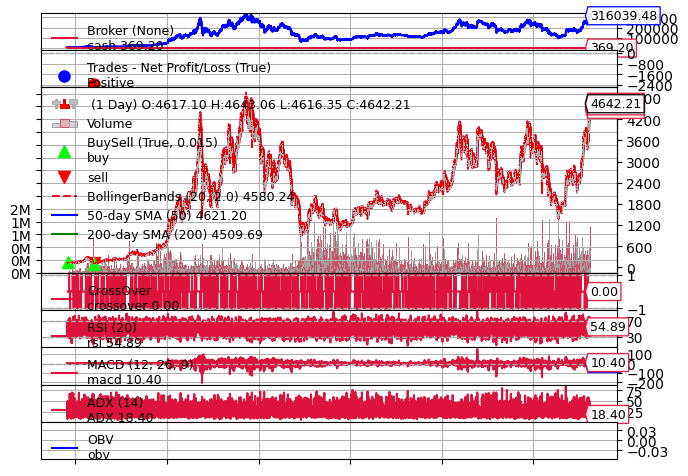

[[<Figure size 640x480 with 9 Axes>]]

In [ ]:
%matplotlib inline
cerebro.plot(
    style='candlestick',
    volume=True,
    iplot=False,
    figsize=(12, 6),
)

In [ ]:
from pprint import pprint

strat = teststrat[0]

print("\n===== 📈 HIỆU SUẤT CHIẾN LƯỢC =====")
print("Sharpe Ratio:")
pprint(strat.analyzers.sharpe.get_analysis())

print("\nAnnual Return (%):")
pprint(strat.analyzers.areturn.get_analysis())

print("\nTổng lợi nhuận:")
pprint(strat.analyzers.returns.get_analysis())

print("\nMức sụt giảm (Drawdown):")
pprint(strat.analyzers.drawdown.get_analysis())

print("\nChi tiết giao dịch (Trade Stats):")
pprint(strat.analyzers.trade.get_analysis())



===== 📈 HIỆU SUẤT CHIẾN LƯỢC =====
Sharpe Ratio:
OrderedDict({'sharperatio': 0.7046650546388029})

Annual Return (%):
OrderedDict([(2019, -0.12048672000000005),
             (2020, 4.741598694223242),
             (2021, 3.9573835249282423),
             (2022, -0.6736259806684279),
             (2023, 0.905304480614004),
             (2024, 0.4598477469821405),
             (2025, 0.3906763053781783)])

Tổng lợi nhuận:
OrderedDict([('rtot', 3.4532820589902715),
             ('ravg', 0.0016530790133988853),
             ('rnorm', 0.5167591362261218),
             ('rnorm100', 51.67591362261218)])

Mức sụt giảm (Drawdown):
AutoOrderedDict([('len', 65931),
                 ('drawdown', 4.320526844180427),
                 ('moneydown', 14271.159999999974),
                 ('max',
                  AutoOrderedDict([('len', 65931),
                                   ('drawdown', 81.33736096417577),
                                   ('moneydown', 268665.95999999996)]))])

Chi tiết giao d